# Imports

The cell below includes all the imports and setup needed to run this notebook. 

In [1]:
# basic python imports
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

# finance imports 
import yfinance as yf

# plotting imports/setup
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# stats imports
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from random import gauss

# modelling imports 
from statsmodels.formula.api import ols
from arch import arch_model
from sklearn.model_selection import GridSearchCV

# Introduction/Purpose

The goal of this notebook is to carry out the following steps for one of the assets in [this investment portfolio](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=1736594093):

1. Create a time series for an asset that exhibits heteroskedasticity, over a period of the previous year based on end of day closing price.
2. Implement an ARCH/GARCH model.
3. Apply the model to the time series that you have created and use it to model the asset risk for the next 10 market days

# Import Data

The cell below reads the data using a `.csv` version of the aforementioned investment portfolio.

In [2]:
investments = pd.read_csv('../Portfolio/investments.csv')
investments['weights'] = investments['initial_investment'] / investments['initial_investment'].sum()
portfolio_start = investments.initial_investment.sum()
investments.head()

,investment_type,GCIS_sector,name,country_of_origin,ticker,price_per_unit,initial_investment,number_of_units,weights
0,stocks,Energy,Exxon Mobil Corp,U.S.,XOM,116.70,400000,3427.592117,0.0500
1,stocks,Energy,PetroChina Co Ltd,China,PCCYF,0.66,400000,606060.606100,0.0500
2,stocks,Energy,NextEra Energy Inc.,U.S.,NEE,68.64,200000,2913.752914,0.0250
3,stocks,Materials,BHP Group Ltd,Austrailia,BHP,58.45,100000,1710.863986,0.0125
4,stocks,Materials,Air Products & Chemicals Inc,U.S.,APD,302.11,100000,331.005263,0.0125


Next, the cell below uses the `yfinance` package to determine the closing prices of each asset in the portfolio over the course of the last year.

In [3]:
tickers = list(investments['ticker'].values)
lookback_date = dt.date.today() - relativedelta(years=1)

close_data = pd.DataFrame()

# have to make separate dataframes because crypto markets don't close
close_data_crypto = pd.DataFrame()

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(period="1y")['Close']
    if row['investment_type'] == 'crypto':
        close_data_crypto[ticker] = tmp
    else:
        close_data[ticker] = tmp

        
close_data = close_data.reset_index()
close_data['Date'] = pd.to_datetime(close_data['Date']).dt.date
close_data = close_data.set_index('Date')

# need to remove times since they "close" at different times
close_data_crypto = close_data_crypto.reset_index()
close_data_crypto['Date'] = pd.to_datetime(close_data_crypto['Date']).dt.date
close_data_crypto = close_data_crypto.set_index('Date')

close_data = close_data.join(close_data_crypto)
close_data = close_data.reset_index()
close_data.head()

,Date,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,...,AMX,NG,IBDRY,PLD,PSA,GOVT,BNDX,LQD,BTC-USD,ETH-USD
0,2022-12-16,101.243340,0.405447,81.829475,59.506702,309.050568,95.824394,205.038589,87.860001,150.229996,...,17.433666,5.73,43.556416,109.162277,274.495819,22.602880,47.663944,104.630119,NaN,NaN
1,2022-12-19,101.697823,0.405447,81.226501,59.156548,306.413452,95.044868,201.312561,84.919998,149.869995,...,17.637966,5.73,43.632946,108.996948,272.541077,22.476339,47.477982,103.574791,16439.679688,1167.609863
2,2022-12-20,103.167641,0.396233,81.226501,59.856857,305.260895,95.668495,200.356689,85.190002,137.800003,...,17.715794,6.09,44.025173,109.103928,270.461792,22.359529,47.125645,102.356384,16906.304688,1217.703613
3,2022-12-21,104.492401,0.396233,82.325470,60.946220,307.165497,97.208076,203.292633,86.769997,137.570007,...,17.910368,6.15,44.302608,110.815666,271.812836,22.388733,47.125645,103.056717,16817.535156,1213.599976
4,2022-12-22,102.384384,0.396233,81.051437,59.730412,305.319519,95.990051,203.526733,83.790001,125.349998,...,17.949284,6.09,44.417404,110.164040,268.286652,22.378994,47.017975,103.027939,16830.341797,1218.182129


# Check for Heteroskedasticity

The cell below performs both a [White test](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html) and a [Breusch-Pagan](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html) for each of the assets in the portfolio. The purpose of each test is to check for heteroskedasticity of the price of the asset over time, which is evidenced when the resultant $p$-value from either test is less than 0.05.

In [4]:
xs = np.arange(close_data.shape[0])
close_data = close_data.assign(xs=xs)
hsktcty = []

for (column_name, column_data) in close_data.iteritems():
    if column_name in ['Date', 'BRK-A', 'BTC-USD', 'ETH-USD']:
        continue
    eqn = f'{column_name}~xs'
    ols_model = ols(formula=eqn, data=close_data).fit()
    white_test_p = het_white(ols_model.resid,  ols_model.model.exog)[1]
    bp_test_p = het_breuschpagan(ols_model.resid, ols_model.model.exog)[1]
    hsktcty.append([column_name, white_test_p, bp_test_p])

hsktcty_df = pd.DataFrame(hsktcty)
hsktcty_df.columns = ['ticker', 'white_p', 'bp_p']
hsktcty_df = hsktcty_df[(hsktcty_df['white_p'] < 0.05) & (hsktcty_df['bp_p'] < 0.05)]
hsktcty_df

,ticker,white_p,bp_p
0,XOM,2.979505e-02,1.485456e-02
1,PCCYF,1.480335e-20,3.472421e-11
2,NEE,6.407047e-03,1.487227e-03
4,APD,1.138810e-02,4.806155e-03
5,RTX,4.856887e-05,5.647389e-05
7,AMZN,9.966775e-04,1.402372e-02
10,BUD,5.339791e-07,1.826264e-07
11,PG,3.363061e-06,5.158936e-07
12,HIMS,1.137484e-09,5.568869e-08
13,PFE,4.782814e-19,1.882836e-13


Based on the results above almost all of the assets in the portfolio exhibit heteroskedasticity, but moving forward `AMZN` will be the choice of asset to test the ARCH/GARCH model.

# AMZN Heteroskedasticity Plots

We can visually confirm the presence of heteroskedasticity for AMZN's stock price by creating residual plots and looking at the closing price differnces over time. 

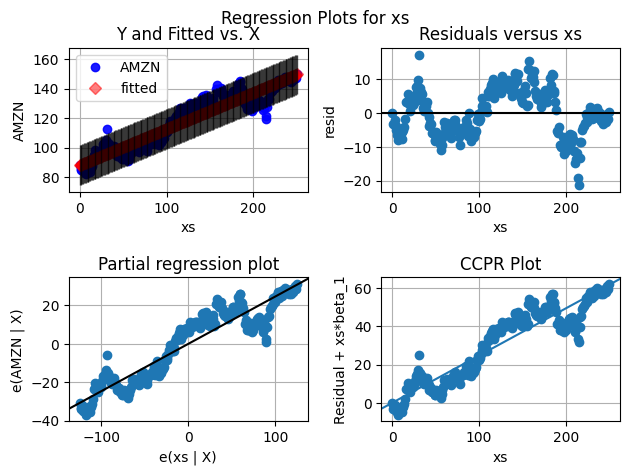

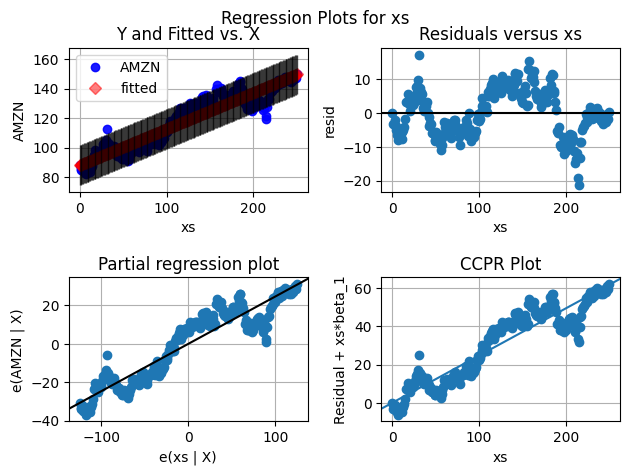

In [5]:
choice = 'AMZN'

df = close_data[['xs', 'Date', choice]]
df[f'{choice}_diff'] = df[f'{choice}'].diff(periods=1)

xom_model = ols(formula=f'{choice}~xs', data=df).fit()
sm.graphics.plot_regress_exog(xom_model, 'xs')

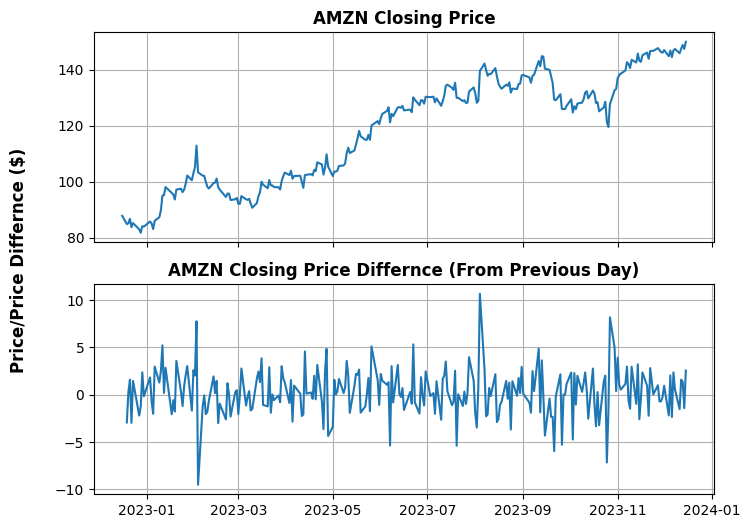

In [6]:
fig, axs = plt.subplots(2, sharex=True)
fig.set_size_inches(8, 6)

fig.supylabel('Price/Price Differnce ($)', fontweight='bold')
axs[0].plot(df['Date'], df[f'{choice}'])
axs[0].set_title(f'{choice} Closing Price', fontweight='bold')
axs[1].plot(df['Date'], df[f'{choice}_diff'])
axs[1].set_title(f'{choice} Closing Price Differnce (From Previous Day)', fontweight='bold')
plt.show()

Both the residual plots and price difference plot are not constant over time, providing the visual evidence necessary that variance is not constant across the pertinent time period (in other words, heteroskedastic) . 

# Build ARCH Model

We can now build an [ARCH](https://www.investopedia.com/terms/a/autoregressive-conditional-heteroskedasticity.asp) model in an attempt to forecast the volatility of the asset for the last 10 days for which we have data. In order to have a benchmark for which to test the predicted volatility provided by the ARCH model, a more simple volatility calculation is performed on all the data by taking the rolling variance of the daily % returns (stored as `test` in the cell below). The ARCH model created below randomly chooses values for two of the input parameters `mean` and `p`. 

In [7]:
num_preds = 10
# use percent returns to model volatility
df['pct_change'] =  df[f'{choice}'].pct_change() * 100
data = df['pct_change'][1:]
train = data[:-num_preds]
test = df['pct_change'].rolling(2).var()[-num_preds:].values
model = arch_model(train, mean='Constant', vol='ARCH', p=50)
arch = model.fit(disp='off')
preds = arch.forecast(horizon=num_preds).variance.values[0]
#mean_squared_error(test, pred)

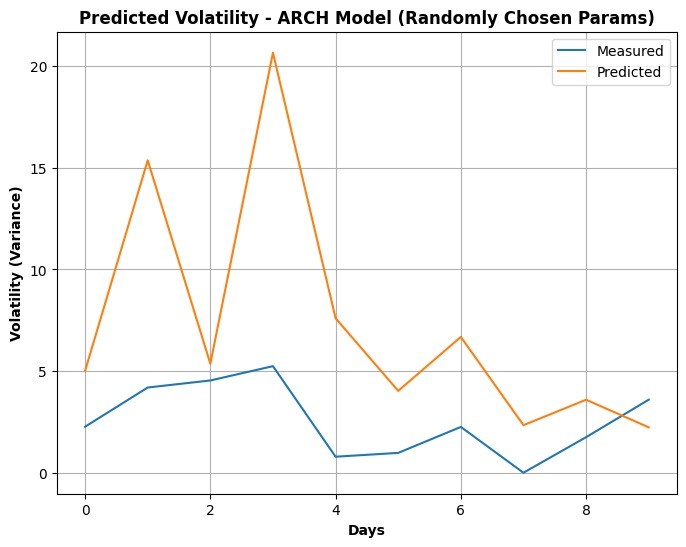

In [8]:
plt.figure(figsize=(8,6))

xs = np.arange(num_preds)
plt.plot(xs, test, label='Measured')
plt.plot(xs, preds, label='Predicted')
plt.ylabel('Volatility (Variance)', fontweight='bold')
plt.xlabel('Days', fontweight='bold')
plt.title('Predicted Volatility - ARCH Model (Randomly Chosen Params)', fontweight='bold')
plt.legend()
plt.show()

As you can see from the plot above, the chosen params seems to overestimate the volatility compared to the measured values. To attempt to fix this, the cell below creates multiple ARCH models using different `mean` and `p` values and selects the best one by calculating the MSE for each. 

In [9]:
u_choices = ['Constant', 'Zero', 'LS', 'AR']
p_choices = [10, 20, 30, 40]
u_choice = u_choices[0]
p_choice = p_choices[0]
mse_best = float("inf")

for u in u_choices:
    for p in p_choices:
        model = arch_model(train, mean=u_choice, vol='ARCH', p=p_choice)
        arch = model.fit(disp='off')
        preds = arch.forecast(horizon=num_preds).variance.values[0]
        mse = mean_squared_error(test, preds)
        if mse < mse_best:
            u_choice = u
            p_choice = p
            mse_best = mse
    
print(f'Best parameters: mean={u_choice}, p={p_choice}')

Best parameters: mean=Constant, p=10


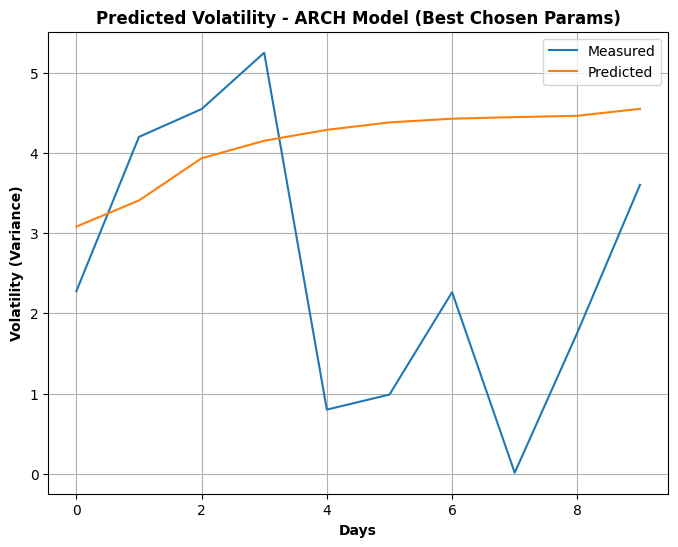

In [10]:
model = arch_model(train, mean=u_choice, vol='ARCH', p=p_choice)
arch = model.fit(disp='off')
preds = arch.forecast(horizon=num_preds).variance.values[0]

plt.figure(figsize=(8,6))

xs = np.arange(num_preds)
plt.plot(xs, test, label='Measured')
plt.plot(xs, preds, label='Predicted')
plt.ylabel('Volatility (Variance)', fontweight='bold')
plt.xlabel('Days', fontweight='bold')
plt.title('Predicted Volatility - ARCH Model (Best Chosen Params)', fontweight='bold')
plt.legend()
plt.show()

Using these parameters the forecast seems to predict that the volatility is smoothing out (but is trending upward), and seems more in line with the measured values. 

# Build GARCH Model

The cells below attempt to find the best [GARCH model](https://www.investopedia.com/terms/g/garch.asp#:~:text=GARCH%20is%20a%20statistical%20modeling,an%20autoregressive%20moving%20average%20process.) to forecast `AMZN`'s volatility. GARCH models are thought to be superior to ARCH models in that they allow the model to: 

1. Model the conditional change in variance over time.
2. Account for changes in the time-dependent variance.

The GARCH model has an additional parameter `q`, which is also included in the selection process here.

In [11]:
u_choices = ['Constant', 'Zero', 'LS', 'AR']
p_choices = [10, 20, 30, 40]
q_choices = [10, 20, 30, 40]
u_choice = u_choices[0]
p_choice = p_choices[0]
q_choice = q_choices[0]
mse_best = float("inf")

for u in u_choices:
    for p in p_choices:
        for q in q_choices:
            model = arch_model(train, mean=u_choice, vol='GARCH', p=p_choice, q=q_choice)
            arch = model.fit(disp='off')
            preds = arch.forecast(horizon=num_preds).variance.values[0]
            mse = mean_squared_error(test, preds)
            if mse < mse_best:
                u_choice = u
                p_choice = p
                q_choice
                mse_best = mse
    
print(f'Best parameters: mean={u_choice}, p={p_choice}')

Best parameters: mean=Constant, p=10


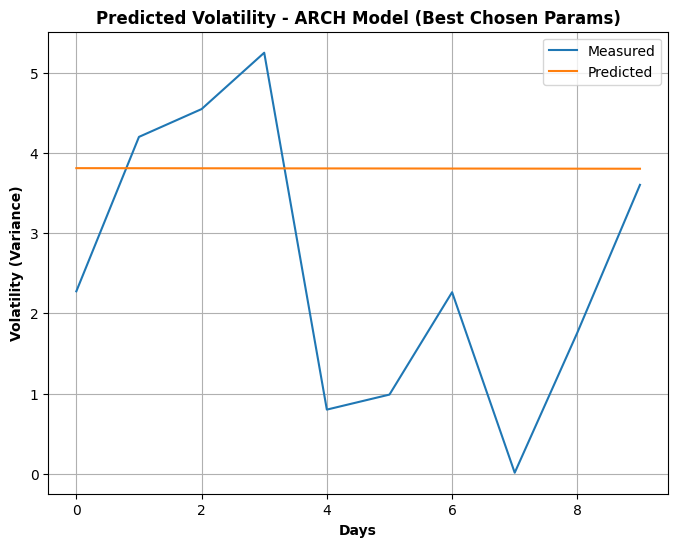

In [12]:
model = arch_model(train, mean=u_choice, vol='GARCH', p=p_choice)
arch = model.fit(disp='off')
preds = arch.forecast(horizon=num_preds).variance.values[0]

plt.figure(figsize=(8,6))

xs = np.arange(num_preds)
plt.plot(xs, test, label='Measured')
plt.plot(xs, preds, label='Predicted')
plt.ylabel('Volatility (Variance)', fontweight='bold')
plt.xlabel('Days', fontweight='bold')
plt.title('Predicted Volatility - ARCH Model (Best Chosen Params)', fontweight='bold')
plt.legend()
plt.show()

As we can see, the GARCH model with the lowest MSE predicts that the volatility of `AMZN` is constant for the last 10 days. 


# Conclusion

Based on the results of the ARCH/GARCH models above, we could have predicted the volatility of `AMZN` to be constant over time period for which it was implemented. However, the accuracy of these ARCH/GARCH models could likely be estimated more accuractely, as the benchmark for the model's success was a simple rolling average of the variance of the daily percentage returns. This could be a next step in this analysis, in order to better understand how to understand and act on the predictions provided by these models. 